In [1]:
##############################################################################################################
# DESCRIPTION: 
#              
# RESULTS:     
#              
##############################################################################################################

In [2]:
######################
# CONFIG & HYPERPARAMS
######################

import os

class HyperParams:
    pass

IMG_PATH = "C:/Projects/VenusDenoise/dataset/cases/64/0001_0100/"

hyperparams = HyperParams()
hyperparams.IMG_WIDTH = 64
hyperparams.IMG_HEIGHT = 64
hyperparams.EPOCHS = 200 # 600 #10000
hyperparams.BATCH_SIZE = 16
hyperparams.START_NEURONS = 8 # UNET
hyperparams.LOSS = 'mean_squared_error'

IMG_WIDTH = hyperparams.IMG_WIDTH
IMG_HEIGHT = hyperparams.IMG_HEIGHT

IMG_CASE = str(IMG_WIDTH) +  "/0001_0100"
MODEL_NAME = "0001_0100-64-unet-xxn4"

IMG_PATH_VALID = IMG_PATH + "validation/"
IMG_PATH_TEST = IMG_PATH + "test/"
IMG_PATH_TRAIN = IMG_PATH

DEST_TESTS = os.path.abspath(os.path.join('../../../out_tests/', MODEL_NAME))

class RadianceLimits:
    pass
radiance_limits = RadianceLimits()
radiance_limits.noisy_min = 0
radiance_limits.noisy_max = 0.0174
radiance_limits.nitid_min = 0
radiance_limits.nitid_max = 0.8130

#from tensorflow.keras.optimizers import Adam
#hyperparams.OPTIMIZER = Adam(learning_rate=0.0001)
#from tensorflow.keras.optimizers import Nadam
#hyperparams.OPTIMIZER = Nadam(learning_rate=0.00001)
from tensorflow.keras.optimizers import RMSprop
hyperparams.OPTIMIZER = RMSprop(learning_rate = 0.0001)

In [3]:
##################
# IMPORTS
##################

import tensorflow as tf
from tensorflow.compat.v1 import InteractiveSession

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

import numpy as np
import tensorflow 
from numpy.random import seed
seed(1)
tensorflow.random.set_seed(2)
import os, sys
module_path = os.path.abspath(os.path.join('../../support/'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import DatasetUtilsTifF as dsutils
import TrainModelD as train
import ReportsK as reports
import UnetI as model_factory

In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

print(f"Tensorflow version: {tf.__version__}")
print(f"Keras Version: {tf.keras.__version__}")
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

tf.config.list_physical_devices('GPU')

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2571381512074659033
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1295983616
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1108376296830078642
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3070 Ti, pci bus id: 0000:2b:00.0, compute capability: 8.6"
]
Tensorflow version: 2.6.0
Keras Version: 2.6.0
GPU is available


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
##################
# MODEL DEFINITION
##################

model = model_factory.buildModel(hyperparams)
model.summary()
model.optimizer.get_config()

Loss=mean_squared_error
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 8)    80          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 8)    584         conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 32, 32, 8)    0           conv2d_1[0][0]                   
______________________________________________________________________

{'name': 'RMSprop',
 'learning_rate': 0.0001,
 'decay': 0.0,
 'rho': 0.9,
 'momentum': 0.0,
 'epsilon': 1e-07,
 'centered': False}

In [6]:
##################
# PREPARE DATA
##################

train_noisy_files, train_nitid_files, train_noisy, train_nitid = \
                dsutils.readDataset( IMG_PATH_TRAIN, hyperparams.IMG_WIDTH, hyperparams.IMG_HEIGHT, radiance_limits)

val_noisy_files, val_nitid_files, val_noisy, val_nitid = \
                dsutils.readDataset( IMG_PATH_VALID, hyperparams.IMG_WIDTH, hyperparams.IMG_HEIGHT, radiance_limits)

train_noisy, train_nitid = \
                dsutils.reshapeDataset( train_noisy, train_nitid, hyperparams.IMG_WIDTH, hyperparams.IMG_HEIGHT )

val_noisy, val_nitid = dsutils.reshapeDataset( val_noisy, val_nitid, hyperparams.IMG_WIDTH, hyperparams.IMG_HEIGHT )

Read dataset. Path: C:/Projects/VenusDenoise/dataset/cases/64/0001_0100/
Noisy files:8086
Nitid files:8086
Read dataset. Path: C:/Projects/VenusDenoise/dataset/cases/64/0001_0100/validation/
Noisy files:2000
Nitid files:2000


In [7]:
##################
# TRAIN MODEL
##################
import tensorflow as tf
from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
set_session(sess)

checkpoint_filepath = os.path.abspath(os.path.join('../../../saves/') + MODEL_NAME \
                                      + "_checkpoint_" + '_weights_{epoch:02d}-{val_loss:.2f}')

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

hist = train.fit( model, hyperparams, train_noisy, train_nitid, val_noisy, val_nitid, patience = 50, \
                 callbacks=[model_checkpoint_callback] )

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 3070 Ti, pci bus id: 0000:2b:00.0, compute capability: 8.6

Epoch 1/200
506/506 [==============================] - 17s 22ms/step - loss: 0.0136 - val_loss: 0.0044
INFO:tensorflow:Assets written to: C:\Projects\VenusDenoise\saves\0001_0100-64-unet-xxn4_checkpoint__weights_01-0.00\assets
Epoch 2/200
506/506 [==============================] - 11s 22ms/step - loss: 0.0032 - val_loss: 0.0037
INFO:tensorflow:Assets written to: C:\Projects\VenusDenoise\saves\0001_0100-64-unet-xxn4_checkpoint__weights_02-0.00\assets
Epoch 3/200
506/506 [==============================] - 11s 21ms/step - loss: 0.0026 - val_loss: 0.0035
INFO:tensorflow:Assets written to: C:\Projects\VenusDenoise\saves\0001_0100-64-unet-xxn4_checkpoint__weights_03-0.00\assets
Epoch 4/200
506/506 [==============================] - 11s 22ms/step - loss: 0.0024 - val_loss: 0.0034
INFO:tensorflow:Assets written to: C:\Projects\VenusDeno

506/506 [==============================] - 11s 21ms/step - loss: 0.0018 - val_loss: 0.0031
Epoch 65/200
506/506 [==============================] - 11s 21ms/step - loss: 0.0017 - val_loss: 0.0031
Epoch 66/200
506/506 [==============================] - 11s 21ms/step - loss: 0.0017 - val_loss: 0.0031
Epoch 67/200
506/506 [==============================] - 11s 21ms/step - loss: 0.0017 - val_loss: 0.0030
Epoch 68/200
506/506 [==============================] - 11s 21ms/step - loss: 0.0017 - val_loss: 0.0029
Epoch 69/200
506/506 [==============================] - 11s 21ms/step - loss: 0.0017 - val_loss: 0.0031
Epoch 70/200
506/506 [==============================] - 11s 21ms/step - loss: 0.0017 - val_loss: 0.0031
Epoch 71/200
506/506 [==============================] - 11s 21ms/step - loss: 0.0017 - val_loss: 0.0031
Epoch 72/200
506/506 [==============================] - 11s 21ms/step - loss: 0.0017 - val_loss: 0.0029
Epoch 73/200
506/506 [==============================] - 11s 21ms/step - loss:

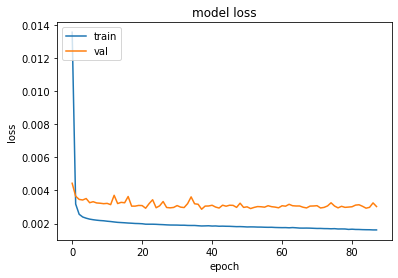

Best Epoch:38


In [8]:
##################
# REPORTS
##################

reports.plotHistory( hist )

In [9]:
model.save(os.path.abspath(os.path.join('../../../saves/', MODEL_NAME)), model)

INFO:tensorflow:Assets written to: C:\Projects\VenusDenoise\saves\0001_0100-64-unet-xxn4\assets


In [10]:
##################
# PREDICTIONS
##################
ACCURACY_THRESHOLD = 0.01
predictions_metrics, predictions_headers \
    = reports.calcPredictionMetrics( model, val_noisy, val_nitid, ACCURACY_THRESHOLD, \
                                    save_pred = True, save_path = DEST_TESTS, \
                                    noisy_files = val_noisy_files, nitid_files = val_nitid_files, \
                                    max_nitid= radiance_limits.nitid_max  )

Images count =2000
Best RMSENZ  =1951 (0.98)
Best MAENZ   =1909 (0.95)
Best PSNR    =1951 (0.98)
Best Accuracy=1657 (0.83)
RMSE-NZ  Pred=0.0459  Noisy=0.1151
MAE-NZ   Pred=0.0381  Noisy=0.0945
PSNR     Pred=12.6 dB Noisy=5.1 dB
Accuracy Pred=0.30    Noisy=0.12
SSM      Pred=0.87    Noisy=0.30
HOG MSE  Pred=0.10    Noisy=0.15


In [11]:
reports.saveMetrics( DEST_TESTS, MODEL_NAME, predictions_headers, predictions_metrics )

Read dataset. Path: C:/Projects/VenusDenoise/dataset/cases/64/0001_0100/test/
Noisy files:15
Nitid files:15
Index:0
C:/Projects/VenusDenoise/dataset/cases/64/0001_0100/test\VI0025_06_00_0_noisy_idx068.tif
C:/Projects/VenusDenoise/dataset/cases/64/0001_0100/test\VI0025_06_00_0_nitid_idx076.tif


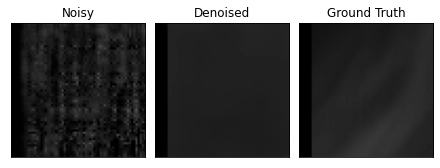

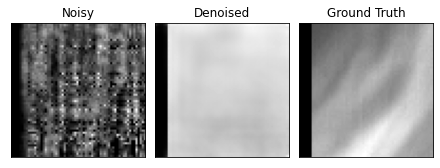

RMSE-NZ  Pred=0.0374  Noisy=0.0762 BEST
MAE-NZ   Pred=0.0285  Noisy=0.0607 BEST
PSNR     Pred=15.5 dB Noisy=9.3 dB BEST
Accuracy Pred=0.24    Noisy=0.11 BEST
SSM      Pred=0.92    Noisy=0.42
HOG MSE  Pred=0.08    Noisy=0.15
******************************************************
Index:1
C:/Projects/VenusDenoise/dataset/cases/64/0001_0100/test\VI0025_07_00_9_noisy_idx068.tif
C:/Projects/VenusDenoise/dataset/cases/64/0001_0100/test\VI0025_07_00_9_nitid_idx076.tif


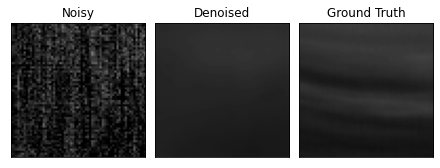

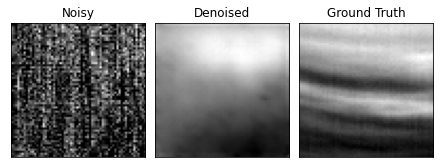

RMSE-NZ  Pred=0.0335  Noisy=0.1043 BEST
MAE-NZ   Pred=0.0274  Noisy=0.0869 BEST
PSNR     Pred=17.6 dB Noisy=7.7 dB BEST
Accuracy Pred=0.19    Noisy=0.06 BEST
SSM      Pred=0.94    Noisy=0.12
HOG MSE  Pred=0.10    Noisy=0.22
******************************************************
Index:2
C:/Projects/VenusDenoise/dataset/cases/64/0001_0100/test\VI0025_07_01_11_noisy_idx089.tif
C:/Projects/VenusDenoise/dataset/cases/64/0001_0100/test\VI0025_07_01_11_nitid_idx076.tif


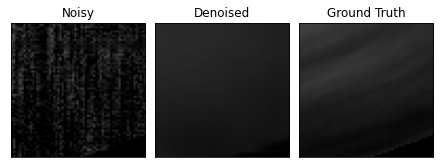

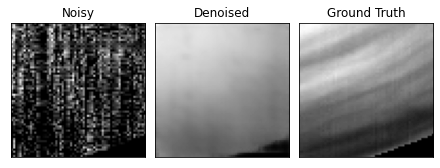

RMSE-NZ  Pred=0.0322  Noisy=0.0960 BEST
MAE-NZ   Pred=0.0263  Noisy=0.0800 BEST
PSNR     Pred=17.9 dB Noisy=8.4 dB BEST
Accuracy Pred=0.26    Noisy=0.06 BEST
SSM      Pred=0.90    Noisy=0.21
HOG MSE  Pred=0.06    Noisy=0.21
******************************************************
Index:3
C:/Projects/VenusDenoise/dataset/cases/64/0001_0100/test\VI0025_07_01_2_noisy_idx089.tif
C:/Projects/VenusDenoise/dataset/cases/64/0001_0100/test\VI0025_07_01_2_nitid_idx076.tif


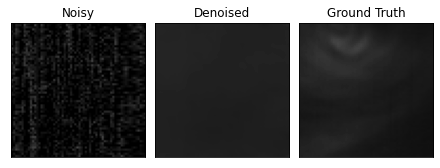

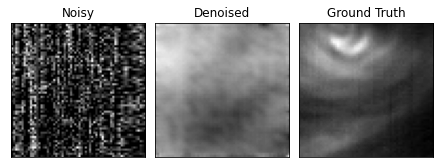

RMSE-NZ  Pred=0.0326  Noisy=0.0938 BEST
MAE-NZ   Pred=0.0266  Noisy=0.0805 BEST
PSNR     Pred=18.3 dB Noisy=9.1 dB BEST
Accuracy Pred=0.21    Noisy=0.06 BEST
SSM      Pred=0.90    Noisy=0.18
HOG MSE  Pred=0.11    Noisy=0.11
******************************************************
Index:4
C:/Projects/VenusDenoise/dataset/cases/64/0001_0100/test\VI0361_04_00_15_noisy_idx068.tif
C:/Projects/VenusDenoise/dataset/cases/64/0001_0100/test\VI0361_04_00_15_nitid_idx076.tif


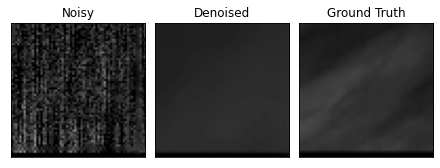

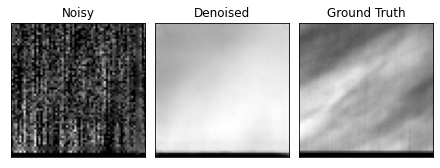

RMSE-NZ  Pred=0.0421  Noisy=0.1126 BEST
MAE-NZ   Pred=0.0324  Noisy=0.0917 BEST
PSNR     Pred=16.7 dB Noisy=8.1 dB BEST
Accuracy Pred=0.20    Noisy=0.07 BEST
SSM      Pred=0.85    Noisy=0.13
HOG MSE  Pred=0.04    Noisy=0.27
******************************************************
Index:5
C:/Projects/VenusDenoise/dataset/cases/64/0001_0100/test\VI0361_04_01_7_noisy_idx089.tif
C:/Projects/VenusDenoise/dataset/cases/64/0001_0100/test\VI0361_04_01_7_nitid_idx076.tif


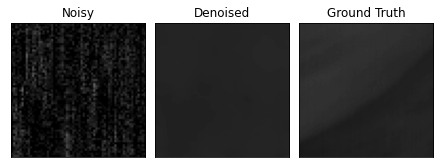

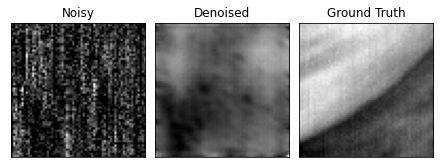

RMSE-NZ  Pred=0.0334  Noisy=0.1147 BEST
MAE-NZ   Pred=0.0276  Noisy=0.1006 BEST
PSNR     Pred=15.9 dB Noisy=5.2 dB BEST
Accuracy Pred=0.23    Noisy=0.05 BEST
SSM      Pred=0.93    Noisy=0.16
HOG MSE  Pred=0.13    Noisy=0.19
******************************************************
Index:6
C:/Projects/VenusDenoise/dataset/cases/64/0001_0100/test\VI0362_04_01_15_noisy_idx089.tif
C:/Projects/VenusDenoise/dataset/cases/64/0001_0100/test\VI0362_04_01_15_nitid_idx076.tif


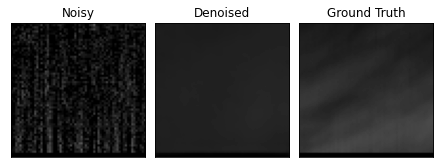

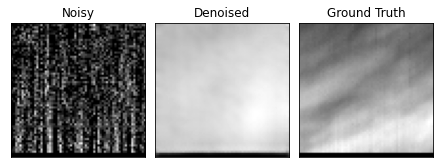

RMSE-NZ  Pred=0.0667  Noisy=0.1357 BEST
MAE-NZ   Pred=0.0506  Noisy=0.1172 BEST
PSNR     Pred=12.8 dB Noisy=6.6 dB BEST
Accuracy Pred=0.22    Noisy=0.04 BEST
SSM      Pred=0.87    Noisy=0.17
HOG MSE  Pred=0.05    Noisy=0.25
******************************************************
Index:7
C:/Projects/VenusDenoise/dataset/cases/64/0001_0100/test\VI0363_00_00_0_noisy_idx068.tif
C:/Projects/VenusDenoise/dataset/cases/64/0001_0100/test\VI0363_00_00_0_nitid_idx076.tif


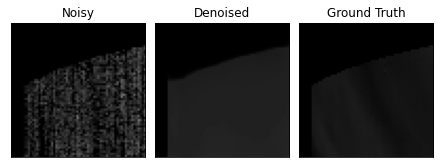

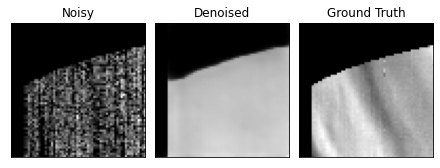

RMSE-NZ  Pred=0.0394  Noisy=0.1015 BEST
MAE-NZ   Pred=0.0305  Noisy=0.0807 BEST
PSNR     Pred=9.4 dB Noisy=1.2 dB BEST
Accuracy Pred=0.34    Noisy=0.10 BEST
SSM      Pred=0.87    Noisy=0.44
HOG MSE  Pred=0.10    Noisy=0.08
******************************************************
Index:8
C:/Projects/VenusDenoise/dataset/cases/64/0001_0100/test\VI0567_01_01_8_noisy_idx089.tif
C:/Projects/VenusDenoise/dataset/cases/64/0001_0100/test\VI0567_01_01_8_nitid_idx076.tif


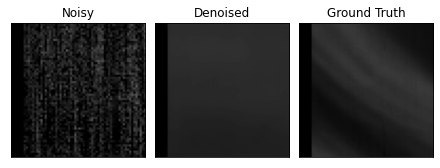

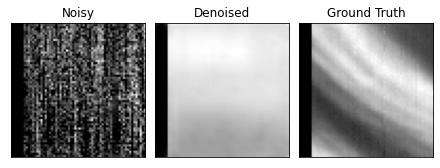

RMSE-NZ  Pred=0.0476  Noisy=0.0960 BEST
MAE-NZ   Pred=0.0363  Noisy=0.0792 BEST
PSNR     Pred=13.6 dB Noisy=7.5 dB BEST
Accuracy Pred=0.24    Noisy=0.07 BEST
SSM      Pred=0.82    Noisy=0.22
HOG MSE  Pred=0.15    Noisy=0.20
******************************************************
Index:9
C:/Projects/VenusDenoise/dataset/cases/64/0001_0100/test\VI0567_02_01_9_noisy_idx089.tif
C:/Projects/VenusDenoise/dataset/cases/64/0001_0100/test\VI0567_02_01_9_nitid_idx076.tif


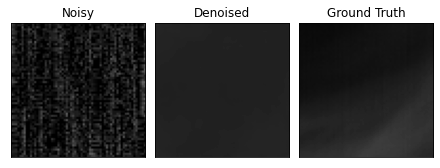

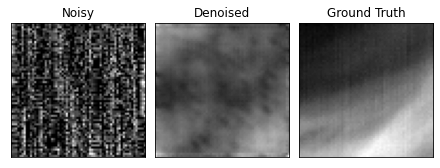

RMSE-NZ  Pred=0.0539  Noisy=0.0971 BEST
MAE-NZ   Pred=0.0467  Noisy=0.0798 BEST
PSNR     Pred=13.1 dB Noisy=8.0 dB BEST
Accuracy Pred=0.12    Noisy=0.07 BEST
SSM      Pred=0.83    Noisy=0.14
HOG MSE  Pred=0.09    Noisy=0.15
******************************************************
Index:10
C:/Projects/VenusDenoise/dataset/cases/64/0001_0100/test\VI0567_03_00_9_noisy_idx068.tif
C:/Projects/VenusDenoise/dataset/cases/64/0001_0100/test\VI0567_03_00_9_nitid_idx076.tif


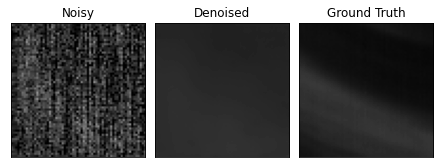

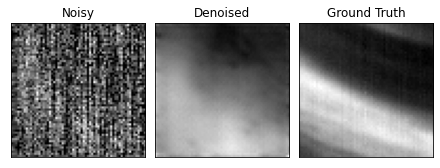

RMSE-NZ  Pred=0.0668  Noisy=0.1540 BEST
MAE-NZ   Pred=0.0568  Noisy=0.1226 BEST
PSNR     Pred=10.5 dB Noisy=3.3 dB BEST
Accuracy Pred=0.10    Noisy=0.05 BEST
SSM      Pred=0.76    Noisy=0.08
HOG MSE  Pred=0.08    Noisy=0.19
******************************************************
Index:11
C:/Projects/VenusDenoise/dataset/cases/64/0001_0100/test\VI0569_02_01_11_noisy_idx089.tif
C:/Projects/VenusDenoise/dataset/cases/64/0001_0100/test\VI0569_02_01_11_nitid_idx076.tif


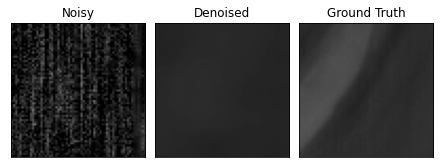

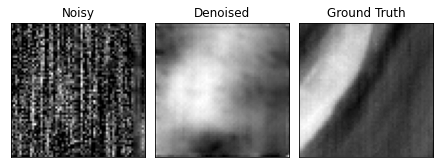

RMSE-NZ  Pred=0.0719  Noisy=0.1426 BEST
MAE-NZ   Pred=0.0552  Noisy=0.1207 BEST
PSNR     Pred=13.3 dB Noisy=7.4 dB BEST
Accuracy Pred=0.08    Noisy=0.04 BEST
SSM      Pred=0.81    Noisy=0.12
HOG MSE  Pred=0.14    Noisy=0.19
******************************************************
Index:12
C:/Projects/VenusDenoise/dataset/cases/64/0001_0100/test\VI0571_02_01_10_noisy_idx089.tif
C:/Projects/VenusDenoise/dataset/cases/64/0001_0100/test\VI0571_02_01_10_nitid_idx076.tif


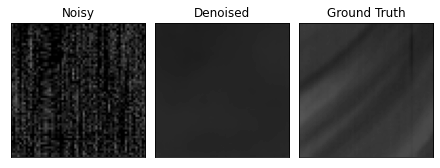

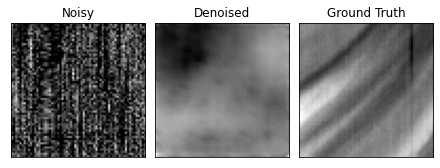

RMSE-NZ  Pred=0.0732  Noisy=0.1416 BEST
MAE-NZ   Pred=0.0641  Noisy=0.1219 BEST
PSNR     Pred=13.3 dB Noisy=7.5 dB BEST
Accuracy Pred=0.05    Noisy=0.04 BEST
SSM      Pred=0.78    Noisy=0.12
HOG MSE  Pred=0.12    Noisy=0.27
******************************************************
Index:13
C:/Projects/VenusDenoise/dataset/cases/64/0001_0100/test\VI0571_03_00_11_noisy_idx068.tif
C:/Projects/VenusDenoise/dataset/cases/64/0001_0100/test\VI0571_03_00_11_nitid_idx076.tif


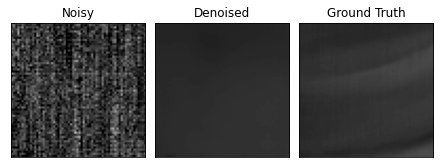

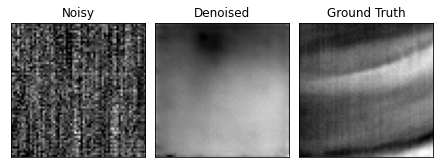

RMSE-NZ  Pred=0.0415  Noisy=0.1312 BEST
MAE-NZ   Pred=0.0317  Noisy=0.1051 BEST
PSNR     Pred=17.2 dB Noisy=7.2 dB BEST
Accuracy Pred=0.23    Noisy=0.05 BEST
SSM      Pred=0.92    Noisy=0.07
HOG MSE  Pred=0.06    Noisy=0.18
******************************************************
Index:14
C:/Projects/VenusDenoise/dataset/cases/64/0001_0100/test\VI0706_02_01_3_noisy_idx089.tif
C:/Projects/VenusDenoise/dataset/cases/64/0001_0100/test\VI0706_02_01_3_nitid_idx076.tif


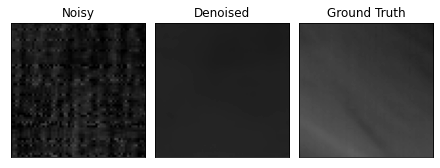

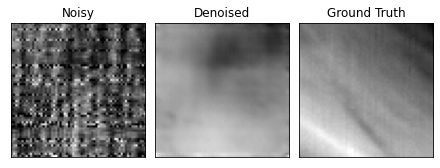

RMSE-NZ  Pred=0.1196  Noisy=0.1634 BEST
MAE-NZ   Pred=0.1130  Noisy=0.1488 BEST
PSNR     Pred=9.7 dB Noisy=7.0 dB BEST
Accuracy Pred=0.00    Noisy=0.01 WORST
SSM      Pred=0.77    Noisy=0.35
HOG MSE  Pred=0.08    Noisy=0.12
******************************************************


In [12]:
test_noisy_files, test_nitid_files, test_noisy, test_nitid = \
    dsutils.readDataset( IMG_PATH_TEST, hyperparams.IMG_WIDTH, hyperparams.IMG_HEIGHT, radiance_limits)

test_noisy, test_nitid = \
    dsutils.reshapeDataset( test_noisy, test_nitid,  hyperparams.IMG_WIDTH, hyperparams.IMG_HEIGHT )

test_indexes = np.arange(0,test_noisy.shape[0])

reports.predictByIndexes( model, test_noisy, test_nitid, test_noisy_files, test_nitid_files, test_indexes, ACCURACY_THRESHOLD )